In [61]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

['data/names/Czech.txt', 'data/names/German.txt', 'data/names/Arabic.txt', 'data/names/Japanese.txt', 'data/names/Chinese.txt', 'data/names/Vietnamese.txt', 'data/names/Kazakh.txt', 'data/names/Russian.txt', 'data/names/French.txt', 'data/names/Irish.txt', 'data/names/English.txt', 'data/names/Spanish.txt', 'data/names/Greek.txt', 'data/names/Italian.txt', 'data/names/Portuguese.txt', 'data/names/Scottish.txt', 'data/names/Dutch.txt', 'data/names/Korean.txt', 'data/names/Polish.txt']
Slusarski


In [62]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


In [63]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


In [64]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [65]:
input = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)

In [66]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-3.0366, -2.9539, -2.9825, -3.0369, -2.8611, -2.9972, -2.9383, -3.0426,
         -2.9552, -2.9697, -2.7981, -2.9001, -2.9528, -2.8122, -2.9608, -3.0096,
         -2.9297, -2.8453, -3.0118]], grad_fn=<LogSoftmaxBackward>)


In [67]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('English', 10)


In [68]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Dutch / line = Houttum
category = Kazakh / line = Ibragimov
category = Portuguese / line = Serafim
category = French / line = Martel
category = Dutch / line = Leeuwenhoek
category = Irish / line = Ruaidh
category = Vietnamese / line = Pham
category = Spanish / line = Ojeda
category = French / line = Baudin
category = Arabic / line = Sabbagh


In [69]:
criterion = nn.NLLLoss()

In [70]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

In [71]:
import time
import math

n_iters = 100000
print_every = 1000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

1000 1% (0m 1s) 2.8463 Callaghan / French ✗ (Irish)
2000 2% (0m 3s) 2.8311 Ronchi / Greek ✗ (Italian)
3000 3% (0m 5s) 2.9864 Hyun  / Japanese ✗ (Korean)
4000 4% (0m 6s) 2.9149 Daly / English ✗ (Irish)
5000 5% (0m 8s) 3.0849 Travert / Italian ✗ (French)
6000 6% (0m 10s) 2.3847 Keegan / Scottish ✗ (English)
7000 7% (0m 12s) 2.5589 Simon / Korean ✗ (Irish)
8000 8% (0m 14s) 2.5131 Agli / Korean ✗ (Italian)
9000 9% (0m 15s) 1.0181 Nurpeisova / Kazakh ✓
10000 10% (0m 17s) 2.3067 Sokolof / Russian ✗ (Polish)
11000 11% (0m 19s) 2.2027 Seow / Korean ✗ (Chinese)
12000 12% (0m 21s) 0.9909 Chung / Vietnamese ✓
13000 13% (0m 22s) 2.0267 Bueren / Dutch ✓
14000 14% (0m 24s) 2.4340 Schuster / Arabic ✗ (German)
15000 15% (0m 26s) 0.7932 Kotsilimbas / Greek ✓
16000 16% (0m 28s) 3.0575 Bazen / Dutch ✗ (Russian)
17000 17% (0m 29s) 1.0281 Ruslanov / Russian ✓
18000 18% (0m 31s) 1.1195 Meng / Chinese ✓
19000 19% (0m 33s) 2.2553 Jamieson / Russian ✗ (Scottish)
20000 20% (0m 34s) 0.1173 Kusuhara / Japanese ✓


In [72]:
print(len(all_losses))

100


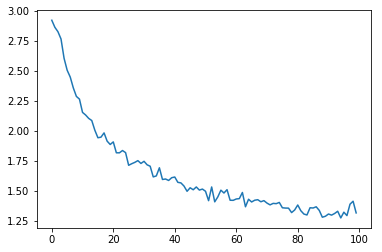

In [73]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)
plt.show()

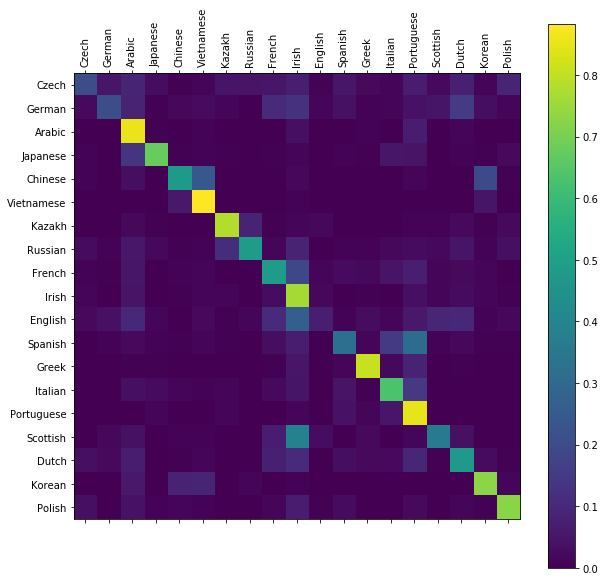

In [74]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [76]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')
predict('Ualikhanov')
predict('Maratkhan')
predict('Ermekova')


> Dovesky
(-0.59) Russian
(-1.31) Czech
(-2.93) Irish

> Jackson
(-0.18) Scottish
(-2.53) English
(-4.20) Greek

> Satoshi
(-1.24) Portuguese
(-1.38) Italian
(-2.23) Polish

> Ualikhanov
(-0.24) Russian
(-1.84) Kazakh
(-3.99) Greek

> Maratkhan
(-0.93) Kazakh
(-1.58) Irish
(-1.98) Russian

> Ermekova
(-0.16) Kazakh
(-2.15) Czech
(-5.08) Spanish


---
### Notes

So, what we have done basically is: first, convert extracted words from the dataset to matrix representations using one-hot encoding. Construct vanilla RNN just by initializing hidden layer as zero for the first iteration, and then passing result of each previous hidden layer to the next input (along with the current input layer). Further, we get output from the current hidden layer, and based on our output we improve our prediction using `NLLLoss`. However, we do not use any optimizers, we just pass the resultant loss at each output to the backpropagation method.

The way we classify lastname is as follows: after converting our word to tensor, we pass it to the network, and at the end we get a vector of size equal to number of classes where each number represent a probability (after softmax), and we just take the maximum probability and classify the lastname according to that.

One thing to mention here is that I didn't see any mention about timesteps we are using in this architecture, that shows how far we can see the context. But I guess we just pass the previous last layer only, so the timesteps is 1.

From the observations we see that our model improves, and the plot of decreasing loss is presented above. Also, from the confusion matrix we see how well the model does on each of the classes. We are only interested in the values that are on the diagonal, because those are correct predictions. English, German, Czech are classified mostly wrong, and Portuguese, Arabic, Vietnamese have best prediction accuracies.

After I increased the dataset with surnames, the prediction has improved. Before changing the dataset the prediction accuracy according to confusion matrix was around 0.4-0.5, and now it has improved to 0.6-0.7. However, because most kazakh lastnames are ending with 'ov' (for male) or 'ova' (for female), kazakh names are misclassified with russian, and russian lastnames are misclassified with kazakh. And it also was observed that russian classification has worsened after adding kazakh dataset.

P.S. Before changing the dataset my lastname was classified as Russian (even if there is no 'ov' in the end), but after changing it, Maratkhan is classified correctly :)

It should also be noted that there exists some noise in the kazakh lastnames dataset. Following are examples:
* Shefer
* Shults
* Bely
* Bozhko
* Kedryuk

The dataset has been collected from following websites:
* http://surnames.nameslist.org/Kazakh/2
* https://en.wikipedia.org/wiki/Category:Kazakh-language_surnames
* https://www.inform.kz/eng/article/2687422
* https://surnames.behindthename.com/submit/names/usage/kazakh
* Some were taken from kazakh intellectuals of Alash time (1916 yr.)